In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# import seaborn as sns
import librosa
import librosa.display
import IPython


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm


In [2]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'

In [3]:
crema = []
for wav in sorted(os.listdir(Crema_Path)):
    emotion = wav.partition(".wav")[0].split('_')
    if emotion[2] == 'SAD':
        crema.append((emotion[0], 'sad', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'ANG':
        crema.append((emotion[0], 'angry', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'DIS':
        crema.append((emotion[0], 'disgust', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'FEA':
        crema.append((emotion[0], 'fear', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'HAP':
        crema.append((emotion[0], 'happy', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'NEU':
        crema.append((emotion[0], 'neutral', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    else:
        crema.append((emotion[0], 'unknown', Crema_Path+'/'+wav, emotion[1], emotion[3]))

df = pd.DataFrame.from_records(crema, columns=['Person', 'Emotion', 'File_Path', 'sentence','intensity'])
df.head()


Person  Emotion                                          File_Path sentence  \
0   1001    angry  ../input/speech-emotion-recognition-en/Crema//...      DFA   
1   1001  disgust  ../input/speech-emotion-recognition-en/Crema//...      DFA   
2   1001     fear  ../input/speech-emotion-recognition-en/Crema//...      DFA   
3   1001    happy  ../input/speech-emotion-recognition-en/Crema//...      DFA   
4   1001  neutral  ../input/speech-emotion-recognition-en/Crema//...      DFA   

  intensity  
0        XX  
1        XX  
2        XX  
3        XX  
4        XX

In [4]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder 
encoder = LabelEncoder()
# Fit the encoder on the column and transform the values
df['Emotion_encoded'] = encoder.fit_transform(df['Emotion'])

# Get the mapping between original labels and encoded values
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
label_mapping

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

In [6]:
df.groupby('Emotion')['intensity'].count()


Emotion
angry      1271
disgust    1271
fear       1271
happy      1271
neutral    1087
sad        1271
Name: intensity, dtype: int64

In [7]:
df['Emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [8]:
def wave_plot(data,sr,emotion):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr)

In [9]:
emotion_names=df['Emotion'].unique()

# Plotting and listening to a sample of each Emotion


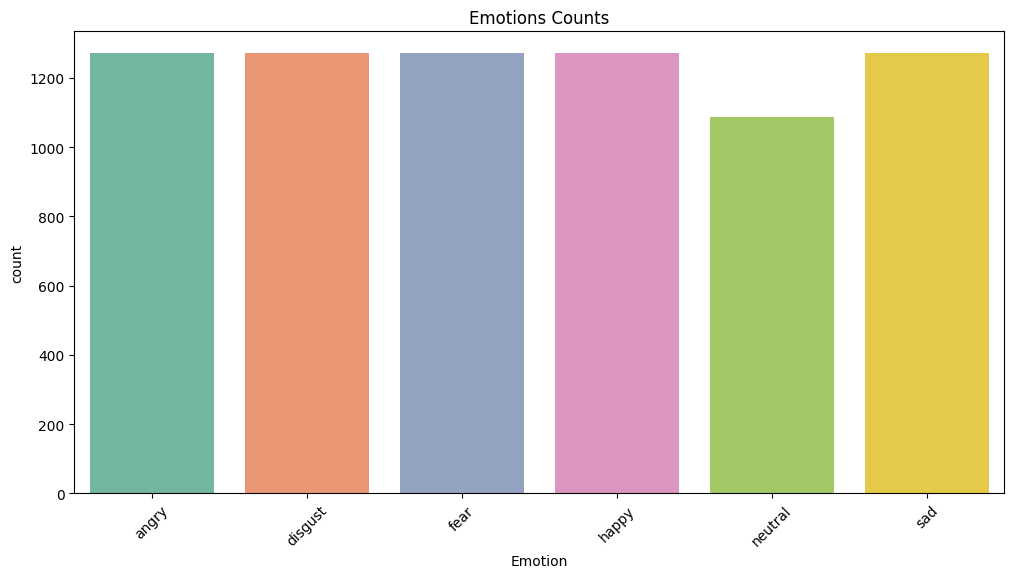

In [10]:
import seaborn as sns
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

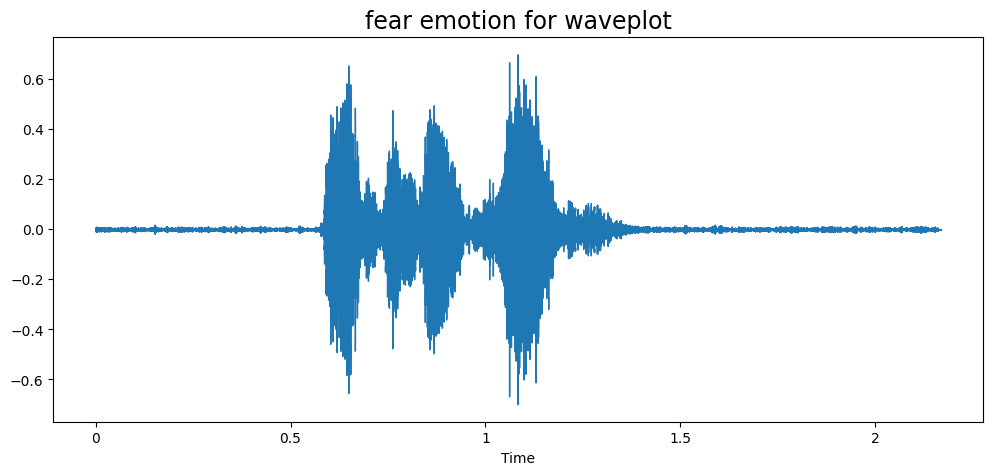

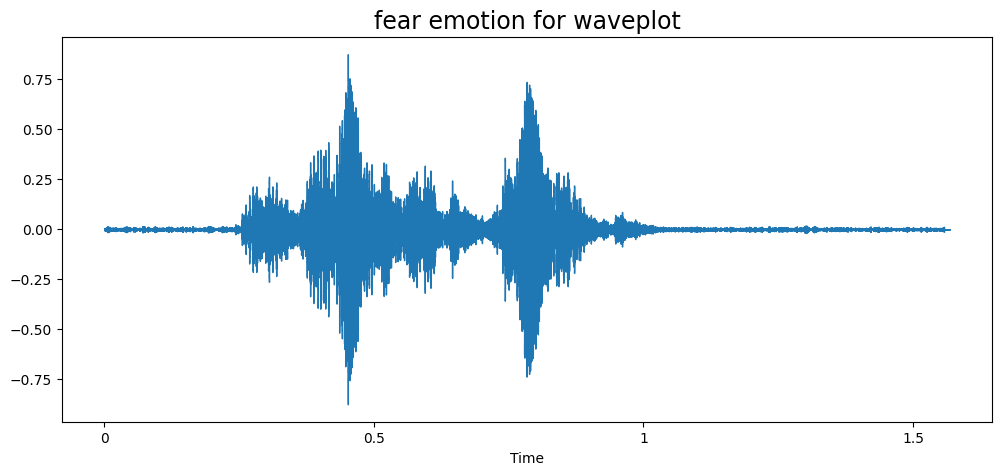

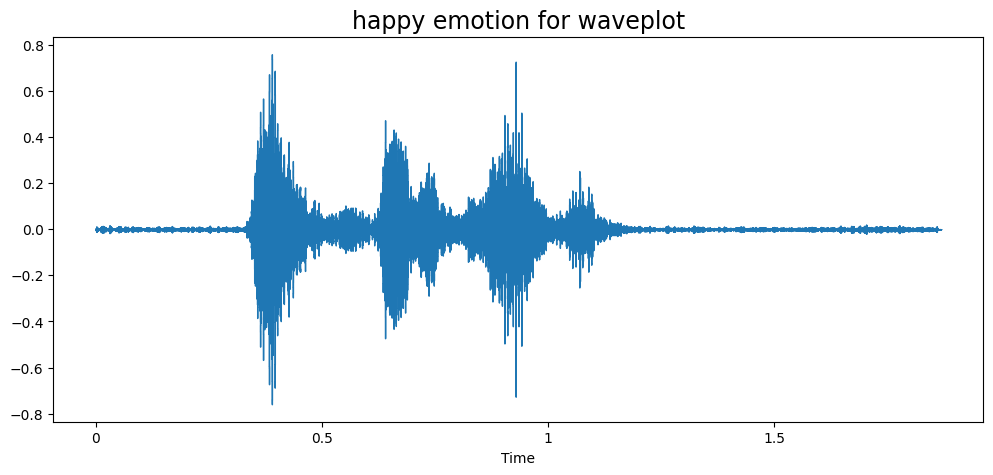

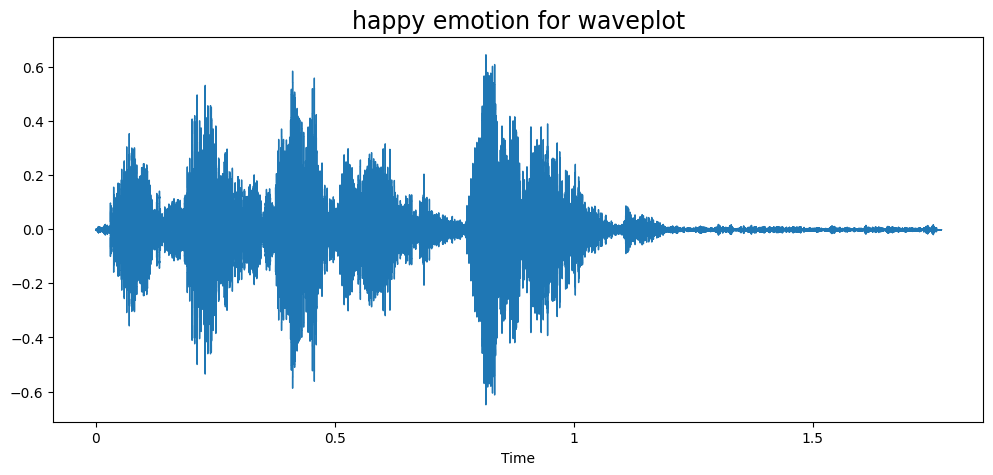

In [11]:
audio_path=[]
for emotion in emotion_names:
    paths=np.array(df['File_Path'][df['Emotion']==emotion])[:2]
    for path in paths:
        data,sr=librosa.load(path)
        wave_plot(data,sr,emotion)
        audio_path.append(path)

In [12]:
i = 0
for emotion in emotion_names:
    print(f'{emotion} Audio Sample\n')
    IPython.display.display(IPython.display.Audio(audio_path[i]))
    print(f'{emotion} Audio Sample\n')
    IPython.display.display(IPython.display.Audio(audio_path[i+1]))
    i+=2

angry Audio Sample



angry Audio Sample



disgust Audio Sample



disgust Audio Sample



fear Audio Sample



fear Audio Sample



happy Audio Sample



happy Audio Sample



neutral Audio Sample



neutral Audio Sample



sad Audio Sample



sad Audio Sample



# Data analysis

**Choosing parameters for melspectogram**

For distinguishing between different emotional states in voice recordings (such as angry, sad, and happy), a suitable value for `n_fft` can vary depending on the specific characteristics of the audio data and the analysis requirements.

a value in the range of 1024 to 4096 is commonly used for speech-related analysis tasks.

**hop_length**

As for the specific value of hop_length, it's common to set it to a fraction of n_fft to achieve a good balance between time and frequency resolution. A typical choice is to set hop_length to half (hop_length = n_fft // 2) or a quarter (hop_length = n_fft // 4) of the n_fft value. In this case, a hop_length value of 512 (hop_length = 2048 // 4) is choosen.

In [13]:
def melspectogram_wave_plot(path,emotion):
    y,sr = librosa.load(path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=265, n_fft=2048 ,hop_length=512)

    S_dB = librosa.power_to_db(S)
    
    fig, ax = plt.subplots()
    img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=f'Mel-frequency spectrogram for {emotion} sound')

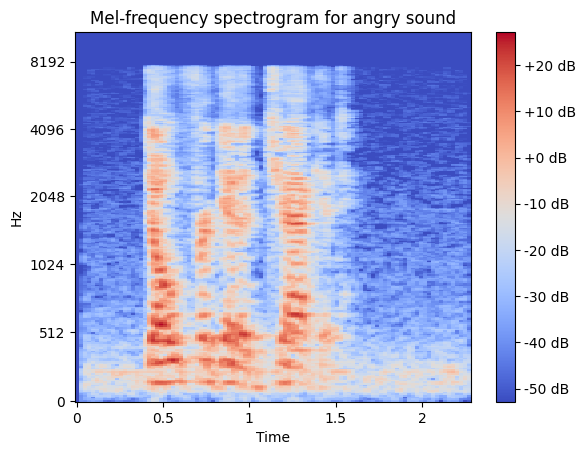

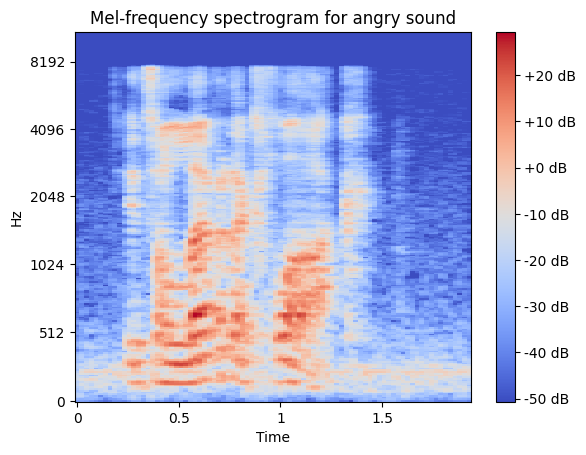

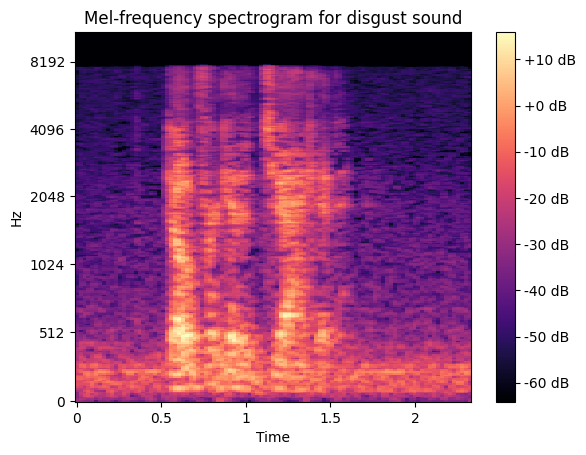

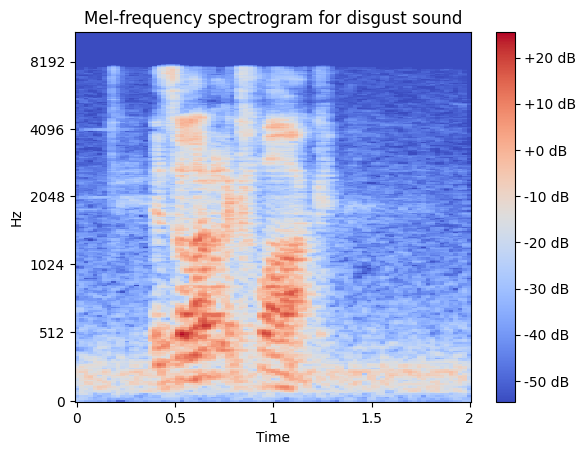

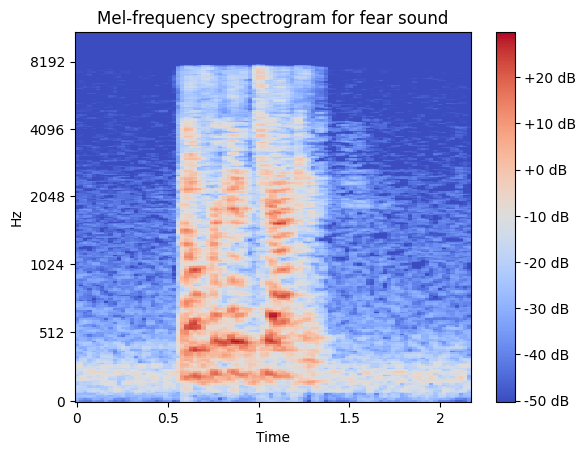

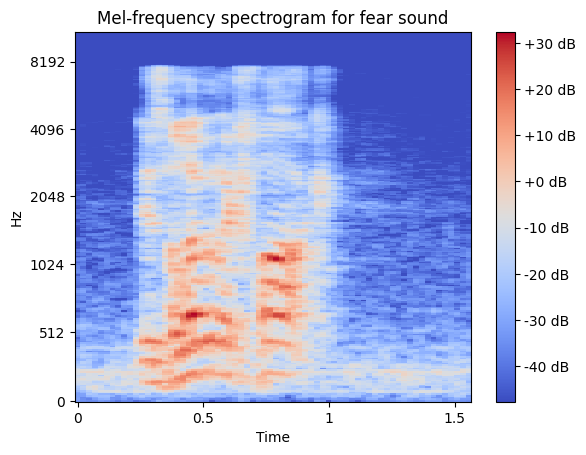

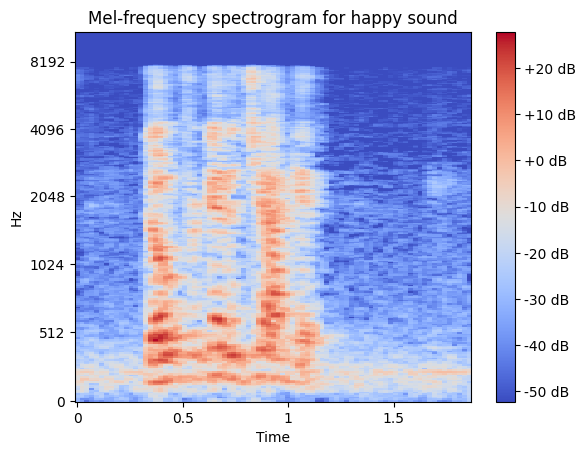

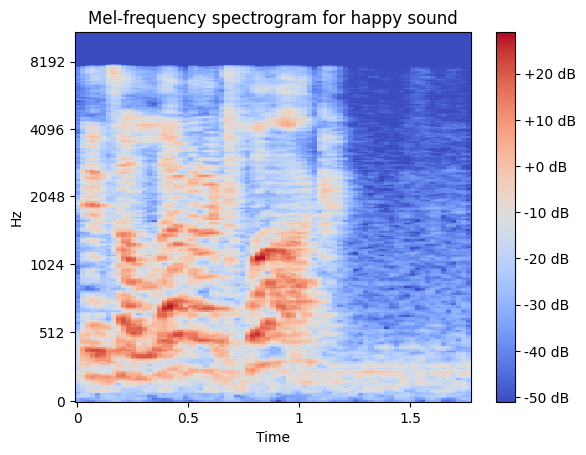

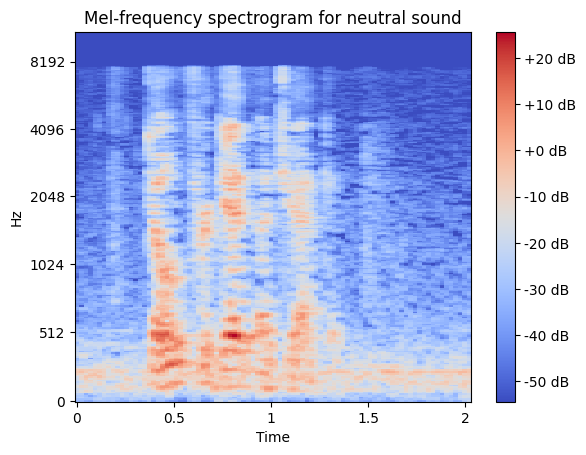

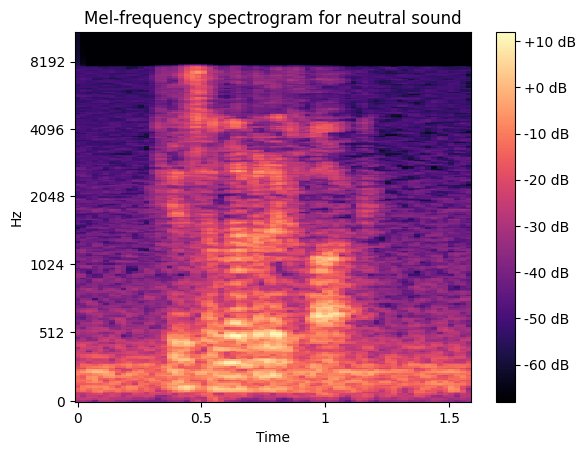

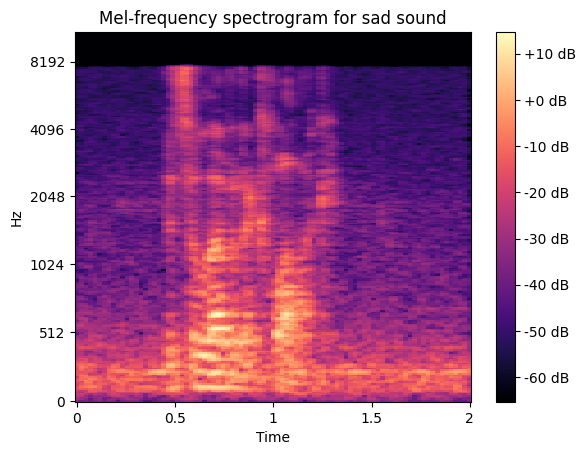

In [14]:
for idx in range(0, len(audio_path), 2):
    melspectogram_wave_plot(audio_path[idx],emotion_names[idx//2])
    melspectogram_wave_plot(audio_path[idx+1],emotion_names[idx//2])

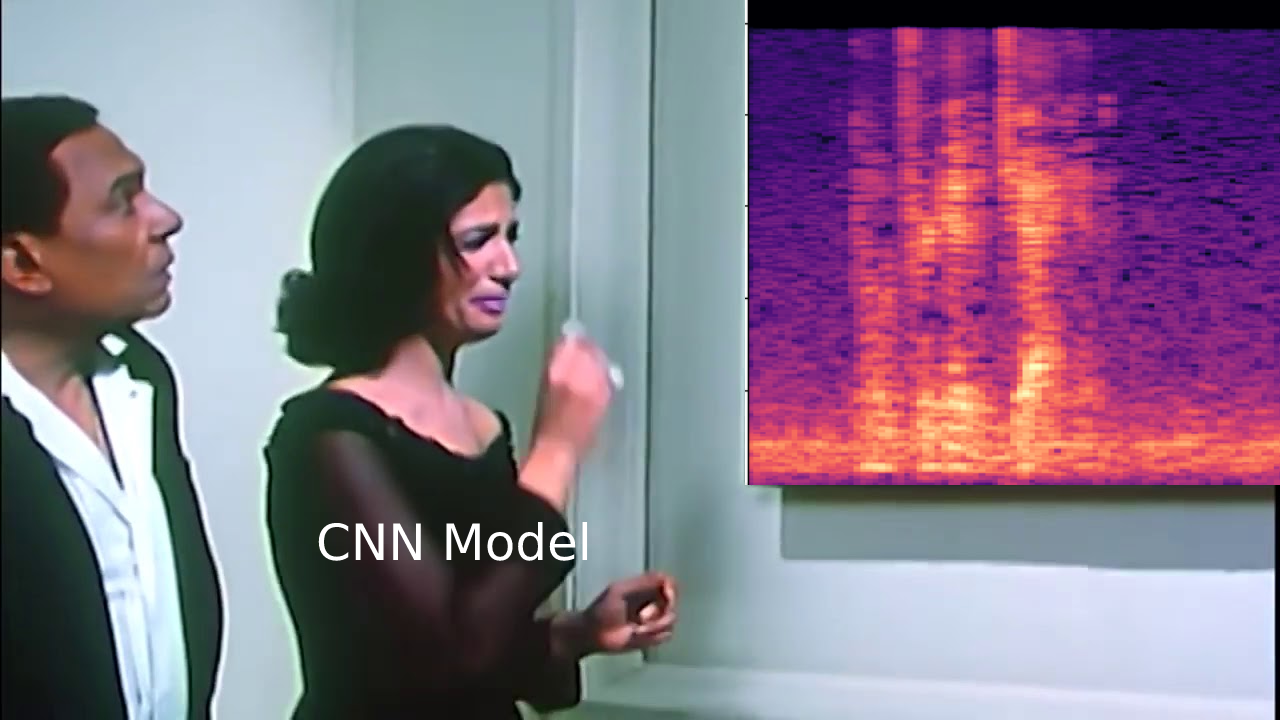

> CNN and neural network models have an astonishing superpower the ability to spot patterns that us humans cannot see or notice at all , like in this picture a CNN model can identify that this is a sad sound :D

In [15]:
!pip install torchaudio

In [10]:
import torchaudio
import torchaudio.transforms as transforms

S_dB_Total = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(df.File_Path)):
    waveform, sample_rate = torchaudio.load(path)
    
    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)

    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())

0it [00:00, ?it/s]/tmp/ipykernel_31/2468677012.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(waveform).to(device)
7442it [01:34, 78.85it/s]


In [11]:
sizes=[]
for x in S_dB_Total:
    sizes.append(x.shape[1])

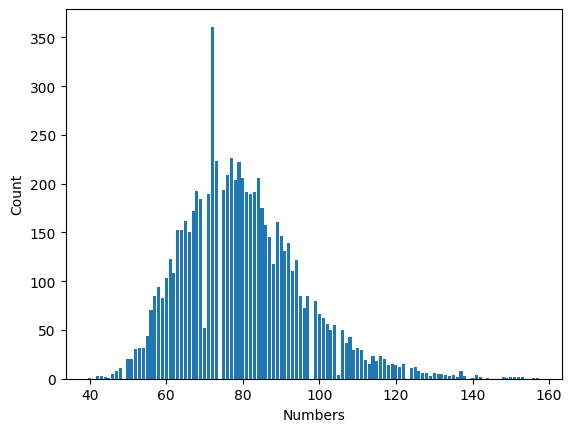

min is 40
max is 157


In [12]:
# Calculate the bin counts
bincount_array = np.histogram(sizes, bins=np.arange(min(sizes), max(sizes)+2))[0]

# Create a list of labels for the x-axis
x_labels = np.arange(min(sizes), max(sizes)+1)

# Plot the bin counts as a bar plot
plt.bar(x_labels, bincount_array)

# Set labels and title
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.show()

print(f'min is {min(sizes)}')
print(f'max is {max(sizes)}')


In [17]:
padding_length = 160
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D = np.array(padded_list)
    

In [18]:
data_2D.shape

(7442, 128, 160)

In [19]:
#normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape the array to 2D
reshaped_data = data_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(data_2D.shape)


In [20]:
normalized_data[1]

array([[0.56973195, 0.5444743 , 0.51813316, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.5450095 , 0.5570548 , 0.541499  , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.512481  , 0.55639714, 0.592978  , ..., 0.64415836, 0.64415836,
        0.64415836],
       ...,
       [0.4755556 , 0.472118  , 0.4689895 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.4661117 , 0.45966327, 0.44934118, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.448575  , 0.45664725, 0.44868642, ..., 0.64415836, 0.64415836,
        0.64415836]], dtype=float32)

In [21]:
data=np.expand_dims(normalized_data, axis=1)

In [22]:
labels=df.Emotion_encoded.to_numpy()

In [23]:
labels.shape

(7442,)

In [24]:
data.shape

(7442, 1, 128, 160)

In [25]:
#train test split
from sklearn.model_selection import train_test_split
# Perform the train-test split (70% train & validation, 30% test )
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Perform the train-validation split (5% test, 95% train)
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size=0.05, stratify=y_trainAndVal, random_state=42)

# Print the sizes of each split
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Train set size: 4948
Validation set size: 261
Test set size: 2233


In [26]:
X_train.shape

(4948, 1, 128, 160)

In [27]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,audio,label):
        self.audios=audio
        self.labels=label

    def __len__(self):
        return len(self.audios)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.audios[idx]
    
    def get_batch_labels(self, idx):
    # Fetch a batch of inputs
        return self.labels[idx]

    
    def __getitem__(self, index):
        audios=self.get_batch_imgs(index)
        labels=self.get_batch_labels(index)
        return audios,labels


In [28]:
train_dataset = AudioDataset(X_train,y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Create a DataLoader from the dataset

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=8, shuffle=False)


# Architecture

# Model 1
* 2 Parallel CNNs


1. AlexNet laid the groundwork for enhancing feature maps by stacking CNN layers and expanding channels.
2. Inception and GoogLeNet introduced the idea of parallelizing CNN layers to diversify the learned features.
3. VGGNet demonstrated the effectiveness of using fixed-sized kernels that we use in each parallel network.


# Model 2
* 2 Parallel CNNs + Transformer Encoder
1. Transformer-Encoder layer from the Attention is All You Need paper


 Transformers allows for capturing both local and global dependencies in the input data. This flexibility enables the model to learn complex patterns and relationships at various scales, enhancing its ability to model intricate structures within the data.


In [59]:
#change nn.sequential to take dict to make more readable 

class ParaNet(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        self.dropout=nn.Dropout(p=0.3)
        self.relu=nn.ReLU()
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,128,160) --> (16,128,80) -> (32,32,20) -> (64,8,5)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),  #(1,128,160) - > (16,128,160)
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size  #(16,128,160) - > (16,64,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(16,64,80) - > (32,64,80)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters #(32,64,80) - > (32,16,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(32,16,20) - > (64,16,20)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(64,16,20) - > (64,4,5)
            nn.Dropout(p=0.4),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,265,160) --> (32,128,80) -> (64,32,20) -> (128,8,5)
        self.conv2Dblock2 = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=32, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),#(1,256,160) - > (32,256,160)
            nn.BatchNorm2d(32), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size (32,265,160) - > (32,128,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=5,
                stride=1,
                padding=2
                      ),#(32,128,55) - > (64,128,55)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters (64,128,55) - > (64,32,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=64,
                out_channels=128, # expand output feature map volume's depth to 64
                kernel_size=7,
                stride=1,
                padding=3
                      ),#(64,32,20) - > (128,32,13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(128,32,13) - > (128,8,5)
            nn.Dropout(p=0.4),
        )
        
        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 6 logits 
        
        # 64*8*5+128*8*5 == 7680 input features --> 6 output emotions 
        self.fc1_linear = nn.Linear(64*4*5 + 128*4*5,num_emotions) 
        
        ### Softmax layer for the 6 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 

        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 

        
        
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2], dim=1)
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        output_softmax = self.softmax_out(output_logits)

        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       


In [29]:
#change nn.sequential to take dict to make more readable 

class ParaNetTransformer(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 256-->512--->256 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=128, # input feature (frequency) dim after maxpooling 128*110 -> 128*27 (Melspectorgram*time)
            nhead=32, # 16 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=1024, # 2 linear layers in each encoder block's feedforward network: dim 128-->512--->128
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=6)

        
        
        self.dropout=nn.Dropout(p=0.3)
        self.relu=nn.ReLU()
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,128,160) --> (16,128,80) -> (32,32,20) -> (64,8,5)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),  #(1,128,160) - > (16,128,160)
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size  #(16,128,160) - > (16,64,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(16,64,80) - > (32,64,80)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters #(32,64,80) - > (32,16,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(32,16,20) - > (64,16,20)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(64,16,20) - > (64,4,5)
            nn.Dropout(p=0.4),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,265,160) --> (32,128,80) -> (64,32,20) -> (128,8,5)
        self.conv2Dblock2 = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=32, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),#(1,256,160) - > (32,256,160)
            nn.BatchNorm2d(32), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size (32,265,160) - > (32,128,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=5,
                stride=1,
                padding=2
                      ),#(32,128,55) - > (64,128,55)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters (64,128,55) - > (64,32,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=64,
                out_channels=128, # expand output feature map volume's depth to 64
                kernel_size=7,
                stride=1,
                padding=3
                      ),#(64,32,20) - > (128,32,13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(128,32,13) - > (128,8,5)
            nn.Dropout(p=0.4),
        )
        
        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 6 logits 
        
        # 64*8*5+128*8*5 == 7680 input features --> 6 output emotions 
        self.fc1_linear = nn.Linear(64*4*5 + 128*4*5 +128,num_emotions) 
        
        ### Softmax layer for the 6 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 

        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 

        
        x_maxpool = self.transformer_maxpool(x)
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        x = x_maxpool_reduced.permute(2,0,1) 
        transformer_output = self.transformer_encoder(x)
        transformer_embedding = torch.mean(transformer_output, dim=0)
        
        
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        output_softmax = self.softmax_out(output_logits)

        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       


In [61]:
from torchinfo import summary
# need device to instantiate model
device = 'cuda'

# instantiate model for 8 emotions and move to GPU 
model = ParaNet(6).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(32, 1, 128, 160))


Layer (type:depth-idx)                   Output Shape              Param #
ParaNet                                  [32, 6]                   --
├─Sequential: 1-1                        [32, 64, 4, 5]            --
│    └─Conv2d: 2-1                       [32, 16, 128, 160]        160
│    └─BatchNorm2d: 2-2                  [32, 16, 128, 160]        32
│    └─ReLU: 2-3                         [32, 16, 128, 160]        --
│    └─MaxPool2d: 2-4                    [32, 16, 64, 80]          --
│    └─Dropout: 2-5                      [32, 16, 64, 80]          --
│    └─Conv2d: 2-6                       [32, 32, 64, 80]          4,640
│    └─BatchNorm2d: 2-7                  [32, 32, 64, 80]          64
│    └─ReLU: 2-8                         [32, 32, 64, 80]          --
│    └─MaxPool2d: 2-9                    [32, 32, 16, 20]          --
│    └─Dropout: 2-10                     [32, 32, 16, 20]          --
│    └─Conv2d: 2-11                      [32, 64, 16, 20]          18,496
│    └─

In [31]:
from torchinfo import summary
# need device to instantiate model
device = 'cuda'

# instantiate model for 8 emotions and move to GPU 
model = ParaNetTransformer(6).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(32, 1, 128, 160))


Layer (type:depth-idx)                        Output Shape              Param #
ParaNetTransformer                            [32, 6]                   --
├─Sequential: 1-1                             [32, 64, 4, 5]            --
│    └─Conv2d: 2-1                            [32, 16, 128, 160]        160
│    └─BatchNorm2d: 2-2                       [32, 16, 128, 160]        32
│    └─ReLU: 2-3                              [32, 16, 128, 160]        --
│    └─MaxPool2d: 2-4                         [32, 16, 64, 80]          --
│    └─Dropout: 2-5                           [32, 16, 64, 80]          --
│    └─Conv2d: 2-6                            [32, 32, 64, 80]          4,640
│    └─BatchNorm2d: 2-7                       [32, 32, 64, 80]          64
│    └─ReLU: 2-8                              [32, 32, 64, 80]          --
│    └─MaxPool2d: 2-9                         [32, 32, 16, 20]          --
│    └─Dropout: 2-10                          [32, 32, 16, 20]          --
│    └─Conv2d: 2

In [62]:
import torch.optim as optim

EPOCHS=500
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn =nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE=1e-4
model = ParaNet(6).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=LEARNING_RATE, momentum=0.8)

In [34]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    for train_input, train_label in tqdm(data_loader):
        train_label = train_label.to(device)
        train_input = train_input.to(device)

        optimizer.zero_grad()
        
        output_logits, output_softmax = model(train_input.float())
        predictions = torch.argmax(output_softmax,dim=1)
        total_predictions += train_label.size(0)
        
        correct_predictions += (predictions == train_label).sum().item()
        
        loss = loss_fn(output_logits, train_label)

        losses.append(loss.item())


        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")

    accuracy = correct_predictions / total_predictions
    mean_loss = np.mean(losses)

    return mean_loss, accuracy


In [35]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():            
        for val_input, val_label in data_loader:
            val_label = val_label.to(device)
            val_input = val_input.to(device)

            optimizer.zero_grad()

            output_logits, output_softmax = model(val_input.float())

            predictions = torch.argmax(output_softmax,dim=1)
            total_predictions += val_label.size(0)

            correct_predictions += (predictions == val_label).sum().item()

            loss = loss_fn(output_logits, val_label)

            losses.append(loss.item())
            
            



        accuracy = correct_predictions / total_predictions
        mean_loss = np.mean(losses)
        

    return mean_loss, accuracy

In [28]:
from collections import defaultdict
import math
history = defaultdict(list)
loss=math.inf
epochs_without_improvement = 0
patience = 20  # Number of epochs to wait for improvement

In [29]:
for epoch in range(EPOCHS):


    train_loss,train_acc = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)
    
    val_loss,val_acc = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print(f'Train loss {train_loss}')
    print(f'Train Accuracy {train_acc}')

    print(f'Val   loss {val_loss}')
    print(f'Val   Acc {val_acc}')

    print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement == patience:
        print("Early stopping triggered. No improvement in", patience, "epochs.")
        break



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    
    history['train_Accuracy'].append(train_acc)
    history['val_Accuracy'].append(val_acc)

    #save this incase of failure
    torch.save(model.state_dict(), 'current_model_state.bin')
    
    
#save last state to train later
torch.save(model.state_dict(), 'last_model_state.bin')


100%|██████████| 619/619 [00:07<00:00, 87.41it/s]


Epoch 1, Learning Rate: 0.0001
Epoch 1/500
----------
Train loss 1.775848720686116
Train Accuracy 0.3213419563459984
Val   loss 1.557287239667141
Val   Acc 0.3793103448275862



100%|██████████| 619/619 [00:06<00:00, 94.68it/s]


Epoch 2, Learning Rate: 0.0001
Epoch 2/500
----------
Train loss 1.5863782279133218
Train Accuracy 0.3654001616814875
Val   loss 1.4013048103361418
Val   Acc 0.4482758620689655



100%|██████████| 619/619 [00:06<00:00, 96.83it/s]


Epoch 3, Learning Rate: 0.0001
Epoch 3/500
----------
Train loss 1.5102341613207186
Train Accuracy 0.4070331447049313
Val   loss 1.3803104884696729
Val   Acc 0.4559386973180077



100%|██████████| 619/619 [00:06<00:00, 97.13it/s]


Epoch 4, Learning Rate: 0.0001
Epoch 4/500
----------
Train loss 1.4640014434477047
Train Accuracy 0.4108730800323363
Val   loss 1.3891418684612622
Val   Acc 0.45977011494252873



100%|██████████| 619/619 [00:06<00:00, 96.71it/s]


Epoch 5, Learning Rate: 0.0001
Epoch 5/500
----------
Train loss 1.421567219428369
Train Accuracy 0.4316895715440582
Val   loss 1.3237263614481145
Val   Acc 0.4904214559386973



100%|██████████| 619/619 [00:06<00:00, 97.15it/s]


Epoch 6, Learning Rate: 0.0001
Epoch 6/500
----------
Train loss 1.4026082330451066
Train Accuracy 0.43532740501212613
Val   loss 1.3514489188338772
Val   Acc 0.4559386973180077



100%|██████████| 619/619 [00:06<00:00, 96.17it/s]


Epoch 7, Learning Rate: 0.0001
Epoch 7/500
----------
Train loss 1.3656604488369721
Train Accuracy 0.46665319320937754
Val   loss 1.2812807776711204
Val   Acc 0.5057471264367817



100%|██████████| 619/619 [00:06<00:00, 96.75it/s]


Epoch 8, Learning Rate: 0.0001
Epoch 8/500
----------
Train loss 1.3461402059564298
Train Accuracy 0.4583670169765562
Val   loss 1.2842422579274033
Val   Acc 0.49808429118773945



100%|██████████| 619/619 [00:06<00:00, 97.48it/s]


Epoch 9, Learning Rate: 0.0001
Epoch 9/500
----------
Train loss 1.3216257976407189
Train Accuracy 0.47554567502021017
Val   loss 1.265314550110788
Val   Acc 0.48659003831417624



100%|██████████| 619/619 [00:06<00:00, 96.71it/s]


Epoch 10, Learning Rate: 0.0001
Epoch 10/500
----------
Train loss 1.2860214096856617
Train Accuracy 0.4911075181891673
Val   loss 1.2397170066833496
Val   Acc 0.5210727969348659



100%|██████████| 619/619 [00:06<00:00, 96.16it/s]


Epoch 11, Learning Rate: 0.0001
Epoch 11/500
----------
Train loss 1.2774000895331479
Train Accuracy 0.4925222312045271
Val   loss 1.3221852309776074
Val   Acc 0.4827586206896552



100%|██████████| 619/619 [00:06<00:00, 96.96it/s]


Epoch 12, Learning Rate: 0.0001
Epoch 12/500
----------
Train loss 1.250245830209652
Train Accuracy 0.4967663702506063
Val   loss 1.2316091476064739
Val   Acc 0.5095785440613027



100%|██████████| 619/619 [00:06<00:00, 97.42it/s]


Epoch 13, Learning Rate: 0.0001
Epoch 13/500
----------
Train loss 1.2315625056792923
Train Accuracy 0.5090945836701698
Val   loss 1.2404189163988286
Val   Acc 0.48659003831417624



100%|██████████| 619/619 [00:06<00:00, 97.26it/s]


Epoch 14, Learning Rate: 0.0001
Epoch 14/500
----------
Train loss 1.2277332029165475
Train Accuracy 0.5179870654810024
Val   loss 1.2227186632878853
Val   Acc 0.5057471264367817



100%|██████████| 619/619 [00:06<00:00, 97.06it/s]


Epoch 15, Learning Rate: 0.0001
Epoch 15/500
----------
Train loss 1.190412636045878
Train Accuracy 0.5379951495553759
Val   loss 1.2287028720884612
Val   Acc 0.4827586206896552



100%|██████████| 619/619 [00:06<00:00, 96.03it/s]


Epoch 16, Learning Rate: 0.0001
Epoch 16/500
----------
Train loss 1.1813284904486914
Train Accuracy 0.5430476960388035
Val   loss 1.2730330888069037
Val   Acc 0.48659003831417624



100%|██████████| 619/619 [00:06<00:00, 96.95it/s]


Epoch 17, Learning Rate: 0.0001
Epoch 17/500
----------
Train loss 1.1601650645544148
Train Accuracy 0.5452708164915118
Val   loss 1.2175957668911328
Val   Acc 0.5095785440613027



100%|██████████| 619/619 [00:06<00:00, 97.39it/s]


Epoch 18, Learning Rate: 0.0001
Epoch 18/500
----------
Train loss 1.1559206834228435
Train Accuracy 0.5513338722716249
Val   loss 1.1907086372375488
Val   Acc 0.5287356321839081



100%|██████████| 619/619 [00:06<00:00, 97.03it/s]


Epoch 19, Learning Rate: 0.0001
Epoch 19/500
----------
Train loss 1.127247740215169
Train Accuracy 0.5650767987065481
Val   loss 1.1757087201783152
Val   Acc 0.5363984674329502



100%|██████████| 619/619 [00:06<00:00, 97.04it/s]


Epoch 20, Learning Rate: 0.0001
Epoch 20/500
----------
Train loss 1.1224817547929113
Train Accuracy 0.553354890864996
Val   loss 1.151280124982198
Val   Acc 0.5517241379310345



100%|██████████| 619/619 [00:06<00:00, 96.13it/s]


Epoch 21, Learning Rate: 0.0001
Epoch 21/500
----------
Train loss 1.1243547813572676
Train Accuracy 0.5547696038803557
Val   loss 1.1693390788454
Val   Acc 0.5325670498084292



100%|██████████| 619/619 [00:06<00:00, 97.02it/s]


Epoch 22, Learning Rate: 0.0001
Epoch 22/500
----------
Train loss 1.1173658260236072
Train Accuracy 0.5632578819725141
Val   loss 1.1630226644602688
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:06<00:00, 97.47it/s]


Epoch 23, Learning Rate: 0.0001
Epoch 23/500
----------
Train loss 1.0810533550617576
Train Accuracy 0.5743734842360549
Val   loss 1.1932804187138875
Val   Acc 0.5210727969348659



100%|██████████| 619/619 [00:06<00:00, 96.98it/s]


Epoch 24, Learning Rate: 0.0001
Epoch 24/500
----------
Train loss 1.092434444749105
Train Accuracy 0.5765966046887632
Val   loss 1.1671335950042263
Val   Acc 0.5172413793103449



100%|██████████| 619/619 [00:06<00:00, 96.89it/s]


Epoch 25, Learning Rate: 0.0001
Epoch 25/500
----------
Train loss 1.0723008746476859
Train Accuracy 0.583872271624899
Val   loss 1.140302640019041
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:06<00:00, 95.97it/s]


Epoch 26, Learning Rate: 0.0001
Epoch 26/500
----------
Train loss 1.0615865685442922
Train Accuracy 0.5810428455941795
Val   loss 1.1461302294875637
Val   Acc 0.5325670498084292



100%|██████████| 619/619 [00:06<00:00, 96.51it/s]


Epoch 27, Learning Rate: 0.0001
Epoch 27/500
----------
Train loss 1.0442288190559732
Train Accuracy 0.5990299110751819
Val   loss 1.1582799355189006
Val   Acc 0.5134099616858238



100%|██████████| 619/619 [00:06<00:00, 96.95it/s]


Epoch 28, Learning Rate: 0.0001
Epoch 28/500
----------
Train loss 1.0467669660517396
Train Accuracy 0.5978172999191592
Val   loss 1.1442044305078911
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:06<00:00, 96.54it/s]


Epoch 29, Learning Rate: 0.0001
Epoch 29/500
----------
Train loss 1.0252929685188996
Train Accuracy 0.6022635408245756
Val   loss 1.2073908430157285
Val   Acc 0.4904214559386973



100%|██████████| 619/619 [00:06<00:00, 96.46it/s]


Epoch 30, Learning Rate: 0.0001
Epoch 30/500
----------
Train loss 1.0345544897874452
Train Accuracy 0.597210994341148
Val   loss 1.230825418775732
Val   Acc 0.48659003831417624



100%|██████████| 619/619 [00:06<00:00, 95.43it/s]


Epoch 31, Learning Rate: 0.0001
Epoch 31/500
----------
Train loss 1.0170182453314978
Train Accuracy 0.6099434114793856
Val   loss 1.0838814088792512
Val   Acc 0.5593869731800766



100%|██████████| 619/619 [00:06<00:00, 96.52it/s]


Epoch 32, Learning Rate: 0.0001
Epoch 32/500
----------
Train loss 1.0168288326032326
Train Accuracy 0.6075181891673404
Val   loss 1.1496109944401365
Val   Acc 0.5095785440613027



100%|██████████| 619/619 [00:06<00:00, 97.49it/s]


Epoch 33, Learning Rate: 0.0001
Epoch 33/500
----------
Train loss 0.9868991661437686
Train Accuracy 0.6265157639450283
Val   loss 1.0757726196086768
Val   Acc 0.5900383141762452



100%|██████████| 619/619 [00:06<00:00, 97.10it/s]


Epoch 34, Learning Rate: 0.0001
Epoch 34/500
----------
Train loss 0.9821203791315221
Train Accuracy 0.6172190784155214
Val   loss 1.1281162536505498
Val   Acc 0.5440613026819924



100%|██████████| 619/619 [00:06<00:00, 96.96it/s]


Epoch 35, Learning Rate: 0.0001
Epoch 35/500
----------
Train loss 0.9673504986121697
Train Accuracy 0.6283346806790623
Val   loss 1.0669132669766743
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:06<00:00, 95.77it/s]


Epoch 36, Learning Rate: 0.0001
Epoch 36/500
----------
Train loss 0.957585196791635
Train Accuracy 0.6210590137429264
Val   loss 1.1538699359604807
Val   Acc 0.524904214559387



100%|██████████| 619/619 [00:06<00:00, 96.24it/s]


Epoch 37, Learning Rate: 0.0001
Epoch 37/500
----------
Train loss 0.9627086075808197
Train Accuracy 0.6360145513338723
Val   loss 1.101189051613663
Val   Acc 0.5593869731800766



100%|██████████| 619/619 [00:06<00:00, 97.14it/s]


Epoch 38, Learning Rate: 0.0001
Epoch 38/500
----------
Train loss 0.9572023457105787
Train Accuracy 0.6218674211802748
Val   loss 1.1424029776544282
Val   Acc 0.5287356321839081



100%|██████████| 619/619 [00:06<00:00, 96.45it/s]


Epoch 39, Learning Rate: 0.0001
Epoch 39/500
----------
Train loss 0.9391096973120685
Train Accuracy 0.6360145513338723
Val   loss 1.0648016893502437
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:06<00:00, 96.09it/s]


Epoch 40, Learning Rate: 0.0001
Epoch 40/500
----------
Train loss 0.9343793449715767
Train Accuracy 0.6416734033953112
Val   loss 1.0941293835639954
Val   Acc 0.524904214559387



100%|██████████| 619/619 [00:06<00:00, 95.67it/s]


Epoch 41, Learning Rate: 0.0001
Epoch 41/500
----------
Train loss 0.921207730912623
Train Accuracy 0.643088116410671
Val   loss 1.0974044592091532
Val   Acc 0.5708812260536399



100%|██████████| 619/619 [00:06<00:00, 96.57it/s]


Epoch 42, Learning Rate: 0.0001
Epoch 42/500
----------
Train loss 0.929978165661191
Train Accuracy 0.6471301535974131
Val   loss 1.0562323340863893
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:06<00:00, 97.37it/s]


Epoch 43, Learning Rate: 0.0001
Epoch 43/500
----------
Train loss 0.9093152619717773
Train Accuracy 0.6455133387227162
Val   loss 1.096987946466966
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:06<00:00, 97.21it/s]


Epoch 44, Learning Rate: 0.0001
Epoch 44/500
----------
Train loss 0.9162992873802324
Train Accuracy 0.6533953112368633
Val   loss 1.0613678386717131
Val   Acc 0.5708812260536399



100%|██████████| 619/619 [00:06<00:00, 95.79it/s]


Epoch 45, Learning Rate: 0.0001
Epoch 45/500
----------
Train loss 0.9019663598936093
Train Accuracy 0.6576394502829426
Val   loss 1.0802127086755
Val   Acc 0.5708812260536399



100%|██████████| 619/619 [00:06<00:00, 96.55it/s]


Epoch 46, Learning Rate: 0.0001
Epoch 46/500
----------
Train loss 0.8710714017006422
Train Accuracy 0.6637025060630558
Val   loss 1.0552968852447742
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:06<00:00, 96.04it/s]


Epoch 47, Learning Rate: 0.0001
Epoch 47/500
----------
Train loss 0.8782068814763345
Train Accuracy 0.6594583670169766
Val   loss 1.0892581795201157
Val   Acc 0.5670498084291188



100%|██████████| 619/619 [00:06<00:00, 97.20it/s]


Epoch 48, Learning Rate: 0.0001
Epoch 48/500
----------
Train loss 0.8822732897586699
Train Accuracy 0.6588520614389652
Val   loss 1.0435379075281548
Val   Acc 0.5977011494252874



100%|██████████| 619/619 [00:06<00:00, 96.64it/s]


Epoch 49, Learning Rate: 0.0001
Epoch 49/500
----------
Train loss 0.8569810669477999
Train Accuracy 0.6659256265157639
Val   loss 1.03572781067906
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:06<00:00, 95.27it/s]


Epoch 50, Learning Rate: 0.0001
Epoch 50/500
----------
Train loss 0.8732119732941103
Train Accuracy 0.6612772837510105
Val   loss 1.0795501154480558
Val   Acc 0.5670498084291188



100%|██████████| 619/619 [00:06<00:00, 96.18it/s]


Epoch 51, Learning Rate: 0.0001
Epoch 51/500
----------
Train loss 0.8620754266834798
Train Accuracy 0.6729991915925626
Val   loss 1.0139978943449077
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:06<00:00, 96.22it/s]


Epoch 52, Learning Rate: 0.0001
Epoch 52/500
----------
Train loss 0.8530831707217197
Train Accuracy 0.6748181083265966
Val   loss 1.0506198343002435
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:06<00:00, 96.99it/s]


Epoch 53, Learning Rate: 0.0001
Epoch 53/500
----------
Train loss 0.846508807290544
Train Accuracy 0.6790622473726758
Val   loss 1.2080780719265793
Val   Acc 0.4942528735632184



100%|██████████| 619/619 [00:06<00:00, 96.47it/s]


Epoch 54, Learning Rate: 0.0001
Epoch 54/500
----------
Train loss 0.8244006057933382
Train Accuracy 0.6859337105901374
Val   loss 1.0138085502566714
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:06<00:00, 95.90it/s]


Epoch 55, Learning Rate: 0.0001
Epoch 55/500
----------
Train loss 0.8247621078194632
Train Accuracy 0.6893694421988682
Val   loss 1.0234711603684858
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:06<00:00, 96.70it/s]


Epoch 56, Learning Rate: 0.0001
Epoch 56/500
----------
Train loss 0.8131771380373657
Train Accuracy 0.6938156831042845
Val   loss 1.0250009307355592
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:06<00:00, 97.05it/s]


Epoch 57, Learning Rate: 0.0001
Epoch 57/500
----------
Train loss 0.8177186877787209
Train Accuracy 0.6877526273241714
Val   loss 1.006308449940248
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:06<00:00, 97.33it/s]


Epoch 58, Learning Rate: 0.0001
Epoch 58/500
----------
Train loss 0.805144041247052
Train Accuracy 0.6938156831042845
Val   loss 1.0110102223627495
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:06<00:00, 96.42it/s]


Epoch 59, Learning Rate: 0.0001
Epoch 59/500
----------
Train loss 0.8012059665072908
Train Accuracy 0.6948261924009701
Val   loss 0.9860436880227291
Val   Acc 0.6436781609195402



100%|██████████| 619/619 [00:06<00:00, 95.83it/s]


Epoch 60, Learning Rate: 0.0001
Epoch 60/500
----------
Train loss 0.7981053211143984
Train Accuracy 0.6952303961196443
Val   loss 1.030429527615056
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:06<00:00, 96.66it/s]


Epoch 61, Learning Rate: 0.0001
Epoch 61/500
----------
Train loss 0.7811332361619191
Train Accuracy 0.6972514147130153
Val   loss 1.050537555506735
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:06<00:00, 96.83it/s]


Epoch 62, Learning Rate: 0.0001
Epoch 62/500
----------
Train loss 0.7784123246186384
Train Accuracy 0.6970493128536782
Val   loss 1.0648579416853008
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:06<00:00, 97.47it/s]


Epoch 63, Learning Rate: 0.0001
Epoch 63/500
----------
Train loss 0.7666072580415714
Train Accuracy 0.7014955537590946
Val   loss 1.118299020059181
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:06<00:00, 96.71it/s]


Epoch 64, Learning Rate: 0.0001
Epoch 64/500
----------
Train loss 0.7608593661873714
Train Accuracy 0.7103880355699272
Val   loss 1.012019331708099
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:06<00:00, 95.13it/s]


Epoch 65, Learning Rate: 0.0001
Epoch 65/500
----------
Train loss 0.7550613111628277
Train Accuracy 0.7152384801940178
Val   loss 1.1196889145807787
Val   Acc 0.5440613026819924



100%|██████████| 619/619 [00:06<00:00, 95.81it/s]


Epoch 66, Learning Rate: 0.0001
Epoch 66/500
----------
Train loss 0.7652908851045014
Train Accuracy 0.711802748585287
Val   loss 1.0311940204013477
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:06<00:00, 96.47it/s]


Epoch 67, Learning Rate: 0.0001
Epoch 67/500
----------
Train loss 0.7504926318835364
Train Accuracy 0.717663702506063
Val   loss 0.9832474670626901
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:06<00:00, 96.68it/s]


Epoch 68, Learning Rate: 0.0001
Epoch 68/500
----------
Train loss 0.7356318903903392
Train Accuracy 0.7186742118027486
Val   loss 1.0205580465721362
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:06<00:00, 94.98it/s]


Epoch 69, Learning Rate: 0.0001
Epoch 69/500
----------
Train loss 0.7320252895018203
Train Accuracy 0.7208973322554567
Val   loss 1.0310562921292854
Val   Acc 0.5900383141762452



100%|██████████| 619/619 [00:06<00:00, 97.06it/s]


Epoch 70, Learning Rate: 0.0001
Epoch 70/500
----------
Train loss 0.7387516796829627
Train Accuracy 0.7164510913500404
Val   loss 0.998707531076489
Val   Acc 0.6245210727969349



100%|██████████| 619/619 [00:06<00:00, 96.78it/s]


Epoch 71, Learning Rate: 0.0001
Epoch 71/500
----------
Train loss 0.726380127889852
Train Accuracy 0.7255456750202102
Val   loss 1.0726037589889583
Val   Acc 0.5632183908045977



100%|██████████| 619/619 [00:06<00:00, 97.07it/s]


Epoch 72, Learning Rate: 0.0001
Epoch 72/500
----------
Train loss 0.7311032609186573
Train Accuracy 0.7213015359741309
Val   loss 1.0169648654533154
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:06<00:00, 97.58it/s]


Epoch 73, Learning Rate: 0.0001
Epoch 73/500
----------
Train loss 0.7147036045308259
Train Accuracy 0.7249393694421988
Val   loss 1.0034700017986875
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:06<00:00, 94.81it/s]


Epoch 74, Learning Rate: 0.0001
Epoch 74/500
----------
Train loss 0.7264764617544769
Train Accuracy 0.7227162489894907
Val   loss 1.019992349725781
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:06<00:00, 96.66it/s]


Epoch 75, Learning Rate: 0.0001
Epoch 75/500
----------
Train loss 0.701458073959886
Train Accuracy 0.7354486661277284
Val   loss 1.0705979954112659
Val   Acc 0.5593869731800766



100%|██████████| 619/619 [00:06<00:00, 96.33it/s]


Epoch 76, Learning Rate: 0.0001
Epoch 76/500
----------
Train loss 0.7003279439142043
Train Accuracy 0.7332255456750202
Val   loss 0.9935073518391812
Val   Acc 0.6360153256704981



100%|██████████| 619/619 [00:06<00:00, 96.86it/s]


Epoch 77, Learning Rate: 0.0001
Epoch 77/500
----------
Train loss 0.6972943212180993
Train Accuracy 0.7330234438156831
Val   loss 1.0217846514600697
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:06<00:00, 97.17it/s]


Epoch 78, Learning Rate: 0.0001
Epoch 78/500
----------
Train loss 0.6759403059033373
Train Accuracy 0.7453516572352465
Val   loss 1.0292507933847832
Val   Acc 0.5977011494252874



100%|██████████| 619/619 [00:06<00:00, 95.10it/s]


Epoch 79, Learning Rate: 0.0001
Epoch 79/500
----------
Train loss 0.6804108377034521
Train Accuracy 0.7407033144704931
Val   loss 1.0053199945074138
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:06<00:00, 97.28it/s]


Epoch 80, Learning Rate: 0.0001
Epoch 80/500
----------
Train loss 0.6655685935343988
Train Accuracy 0.7528294260307195
Val   loss 1.0024225278334185
Val   Acc 0.6245210727969349



100%|██████████| 619/619 [00:06<00:00, 96.54it/s]


Epoch 81, Learning Rate: 0.0001
Epoch 81/500
----------
Train loss 0.6701664988053827
Train Accuracy 0.7449474535165723
Val   loss 1.0126321893749815
Val   Acc 0.6091954022988506



100%|██████████| 619/619 [00:06<00:00, 96.96it/s]


Epoch 82, Learning Rate: 0.0001
Epoch 82/500
----------
Train loss 0.6663835591520747
Train Accuracy 0.7512126111560227
Val   loss 1.0176527138912317
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:06<00:00, 96.53it/s]


Epoch 83, Learning Rate: 0.0001
Epoch 83/500
----------
Train loss 0.6717533640960692
Train Accuracy 0.7473726758286177
Val   loss 1.0185507039229076
Val   Acc 0.6245210727969349



100%|██████████| 619/619 [00:06<00:00, 92.79it/s]


Epoch 84, Learning Rate: 0.0001
Epoch 84/500
----------
Train loss 0.6577867962335732
Train Accuracy 0.7534357316087308
Val   loss 0.9852601632927404
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:06<00:00, 97.47it/s]


Epoch 85, Learning Rate: 0.0001
Epoch 85/500
----------
Train loss 0.6404082361542544
Train Accuracy 0.7510105092966856
Val   loss 1.0251155455004086
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:06<00:00, 96.53it/s]


Epoch 86, Learning Rate: 0.0001
Epoch 86/500
----------
Train loss 0.6473755914483201
Train Accuracy 0.75767987065481
Val   loss 1.0152637782421978
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:06<00:00, 96.98it/s]


Epoch 87, Learning Rate: 0.0001
Epoch 87/500
----------
Train loss 0.6529460502893744
Train Accuracy 0.7528294260307195
Val   loss 0.9875814910187866
Val   Acc 0.6206896551724138

Early stopping triggered. No improvement in 20 epochs.


In [63]:
model.load_state_dict(torch.load('/kaggle/working/best_model_state.bin'))

<All keys matched successfully>

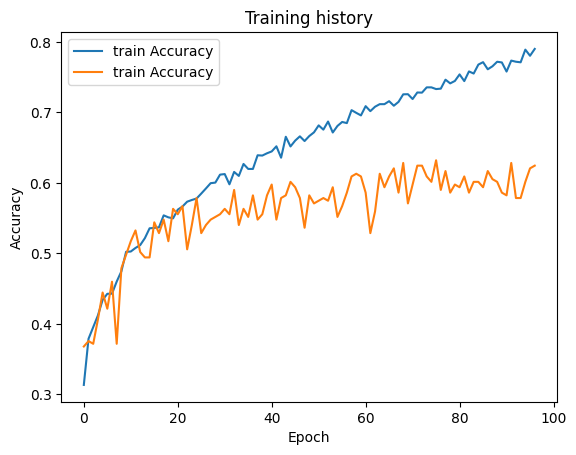

In [57]:
plt.plot(history['train_Accuracy'], label='train Accuracy')
plt.plot(history['val_Accuracy'], label='train Accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


In [32]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()


In [37]:
def get_predicted(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for test_input, test_label in data_loader:
            test_label = test_label.to(device)
            test_input = test_input.to(device)

            output_logits, output_softmax = model(test_input.float())

            predictions = torch.argmax(output_softmax, dim=1)
            predicted_labels.extend(predictions.cpu().numpy())
            true_labels.extend(test_label.cpu().numpy())

            loss = loss_fn(output_logits, test_label)
            losses.append(loss.item())

    mean_loss = np.mean(losses)

    return mean_loss, predicted_labels, true_labels

In [64]:
mean_loss, predicted_labels, true_labels=get_predicted(model,test_dataloader,loss_fn,DEVICE)

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def measurements_of_accuracy(Y_test,Y_pred,classifier,labels):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
    matrix_precentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title("Confusion Matrix for "+classifier+"Classifier", fontsize=18)
    plt.grid(False)
    plt.xticks(range(len(labels)), labels, rotation=90)  # Set x-axis labels
    plt.yticks(range(len(labels)), labels)  # Set y-axis labels
    plt.show()
    
    #Accuracy
    print('Accuracy : %.4f' % accuracy_score(Y_test, Y_pred))

    #precision score
    print('Precision : %.4f' % precision_score(Y_test, Y_pred,average='macro'))
    
    #Recall Score
    print('Recall : %.4f' % recall_score(Y_test, Y_pred,average='macro'))
    
    #F1 score
    print('F1 Score : %.4f' % f1_score(Y_test, Y_pred,average='macro'))
    
        # Find the most confusing classes
    misclassification_rates = 1 - np.diag(matrix_precentage)
    most_confusing_classes = [labels[i] for i in np.argsort(misclassification_rates)[::-1]]
    print("Most Confusing Classes:")
    for i, label in enumerate(most_confusing_classes):
        rate_percentage = misclassification_rates[i] * 100
        print(f"{i + 1}. {label}: {rate_percentage:.2f}% (Misclassification rate)")


In [36]:
label_mapping

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

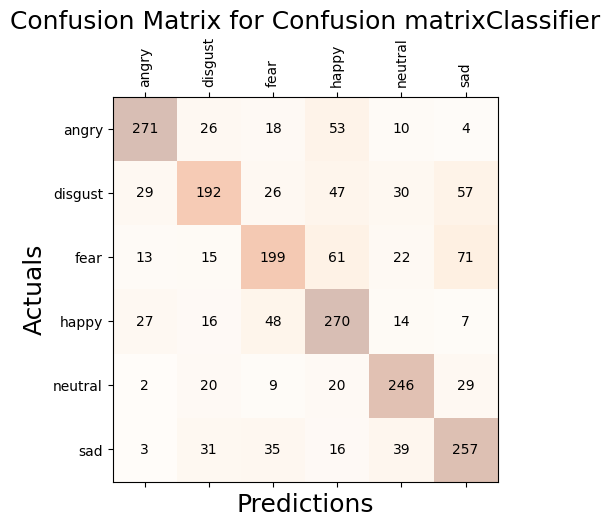

Accuracy : 0.6426
Precision : 0.6473
Recall : 0.6453
F1 Score : 0.6425
Most Confusing Classes:
1. disgust: 29.06% (Misclassification rate)
2. fear: 49.61% (Misclassification rate)
3. sad: 47.77% (Misclassification rate)
4. happy: 29.32% (Misclassification rate)
5. angry: 24.54% (Misclassification rate)
6. neutral: 32.55% (Misclassification rate)


In [65]:
measurements_of_accuracy(true_labels,predicted_labels,"Confusion matrix",list(label_mapping.keys()))

# MODEL 2 Training

In [32]:
import torch.optim as optim

EPOCHS=500
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn =nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE=1e-4
model = ParaNetTransformer(6).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [33]:
from collections import defaultdict
import math
history = defaultdict(list)
loss=math.inf
epochs_without_improvement = 0
patience = 20  # Number of epochs to wait for improvement

In [39]:
for epoch in range(EPOCHS):


    train_loss,train_acc = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)
    
    val_loss,val_acc = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print(f'Train loss {train_loss}')
    print(f'Train Accuracy {train_acc}')

    print(f'Val   loss {val_loss}')
    print(f'Val   Acc {val_acc}')

    print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement == patience:
        print("Early stopping triggered. No improvement in", patience, "epochs.")
        break



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    
    history['train_Accuracy'].append(train_acc)
    history['val_Accuracy'].append(val_acc)

    #save this incase of failure
    torch.save(model.state_dict(), 'current_model_state.bin')
    
    
#save last state to train later
torch.save(model.state_dict(), 'last_model_state.bin')


100%|██████████| 619/619 [00:12<00:00, 47.92it/s]


Epoch 1, Learning Rate: 0.0001
Epoch 1/500
----------
Train loss 1.4102111648473292
Train Accuracy 0.43391269199676635
Val   loss 1.3250926480148777
Val   Acc 0.4444444444444444



100%|██████████| 619/619 [00:14<00:00, 43.77it/s]


Epoch 2, Learning Rate: 0.0001
Epoch 2/500
----------
Train loss 1.3864258846481705
Train Accuracy 0.44260307194826193
Val   loss 1.416465598525423
Val   Acc 0.421455938697318



100%|██████████| 619/619 [00:12<00:00, 49.41it/s]


Epoch 3, Learning Rate: 0.0001
Epoch 3/500
----------
Train loss 1.3736634691620488
Train Accuracy 0.44280517380759904
Val   loss 1.3399899638060369
Val   Acc 0.45977011494252873



100%|██████████| 619/619 [00:12<00:00, 47.94it/s]


Epoch 4, Learning Rate: 0.0001
Epoch 4/500
----------
Train loss 1.3379610826972999
Train Accuracy 0.459983831851253
Val   loss 1.4524370179031834
Val   Acc 0.3716475095785441



100%|██████████| 619/619 [00:12<00:00, 49.55it/s]


Epoch 5, Learning Rate: 0.0001
Epoch 5/500
----------
Train loss 1.308090949385925
Train Accuracy 0.47453516572352467
Val   loss 1.3320691639726812
Val   Acc 0.4789272030651341



100%|██████████| 619/619 [00:13<00:00, 47.31it/s]


Epoch 6, Learning Rate: 0.0001
Epoch 6/500
----------
Train loss 1.2753397719347805
Train Accuracy 0.5022231204527081
Val   loss 1.271973911559943
Val   Acc 0.49808429118773945



100%|██████████| 619/619 [00:13<00:00, 46.34it/s]


Epoch 7, Learning Rate: 0.0001
Epoch 7/500
----------
Train loss 1.263731765727812
Train Accuracy 0.5026273241713823
Val   loss 1.2030389688231728
Val   Acc 0.5172413793103449



100%|██████████| 619/619 [00:12<00:00, 49.39it/s]


Epoch 8, Learning Rate: 0.0001
Epoch 8/500
----------
Train loss 1.2591129375293681
Train Accuracy 0.50767987065481
Val   loss 1.219758801388018
Val   Acc 0.5325670498084292



100%|██████████| 619/619 [00:12<00:00, 48.30it/s]


Epoch 9, Learning Rate: 0.0001
Epoch 9/500
----------
Train loss 1.2312045378523226
Train Accuracy 0.5117219078415521
Val   loss 1.2295112086064888
Val   Acc 0.5019157088122606



100%|██████████| 619/619 [00:12<00:00, 49.80it/s]


Epoch 10, Learning Rate: 0.0001
Epoch 10/500
----------
Train loss 1.2202299641676981
Train Accuracy 0.5216248989490704
Val   loss 1.249722092440634
Val   Acc 0.4942528735632184



100%|██████████| 619/619 [00:12<00:00, 48.10it/s]


Epoch 11, Learning Rate: 0.0001
Epoch 11/500
----------
Train loss 1.1932724727760031
Train Accuracy 0.5355699272433306
Val   loss 1.202915047154282
Val   Acc 0.4942528735632184



100%|██████████| 619/619 [00:12<00:00, 49.31it/s]


Epoch 12, Learning Rate: 0.0001
Epoch 12/500
----------
Train loss 1.1833048480200268
Train Accuracy 0.536176232821342
Val   loss 1.1627031420216416
Val   Acc 0.5440613026819924



100%|██████████| 619/619 [00:12<00:00, 49.61it/s]


Epoch 13, Learning Rate: 0.0001
Epoch 13/500
----------
Train loss 1.174219018615698
Train Accuracy 0.5369846402586904
Val   loss 1.181140995386875
Val   Acc 0.5287356321839081



100%|██████████| 619/619 [00:12<00:00, 48.39it/s]


Epoch 14, Learning Rate: 0.0001
Epoch 14/500
----------
Train loss 1.1517721889766237
Train Accuracy 0.5539611964430072
Val   loss 1.1670141545209018
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:12<00:00, 49.61it/s]


Epoch 15, Learning Rate: 0.0001
Epoch 15/500
----------
Train loss 1.146372830540375
Train Accuracy 0.5511317704122878
Val   loss 1.1633346189152112
Val   Acc 0.5172413793103449



100%|██████████| 619/619 [00:12<00:00, 47.81it/s]


Epoch 16, Learning Rate: 0.0001
Epoch 16/500
----------
Train loss 1.1371543048753108
Train Accuracy 0.549717057396928
Val   loss 1.117080847422282
Val   Acc 0.5632183908045977



100%|██████████| 619/619 [00:12<00:00, 49.14it/s]


Epoch 17, Learning Rate: 0.0001
Epoch 17/500
----------
Train loss 1.1134318540862767
Train Accuracy 0.5620452708164915
Val   loss 1.1234290383078835
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:12<00:00, 49.30it/s]


Epoch 18, Learning Rate: 0.0001
Epoch 18/500
----------
Train loss 1.1207464583374571
Train Accuracy 0.5664915117219078
Val   loss 1.1045149311874851
Val   Acc 0.5670498084291188



100%|██████████| 619/619 [00:12<00:00, 47.98it/s]


Epoch 19, Learning Rate: 0.0001
Epoch 19/500
----------
Train loss 1.0971095403099675
Train Accuracy 0.5733629749393695
Val   loss 1.1902402187838699
Val   Acc 0.5057471264367817



100%|██████████| 619/619 [00:12<00:00, 49.62it/s]


Epoch 20, Learning Rate: 0.0001
Epoch 20/500
----------
Train loss 1.0776922016228536
Train Accuracy 0.5757881972514147
Val   loss 1.1381165385246277
Val   Acc 0.5402298850574713



100%|██████████| 619/619 [00:12<00:00, 48.18it/s]


Epoch 21, Learning Rate: 0.0001
Epoch 21/500
----------
Train loss 1.0693803821511338
Train Accuracy 0.5778092158447857
Val   loss 1.0815199613571167
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 49.73it/s]


Epoch 22, Learning Rate: 0.0001
Epoch 22/500
----------
Train loss 1.0679701288412768
Train Accuracy 0.5848827809215845
Val   loss 1.1388997814872048
Val   Acc 0.5287356321839081



100%|██████████| 619/619 [00:12<00:00, 49.39it/s]


Epoch 23, Learning Rate: 0.0001
Epoch 23/500
----------
Train loss 1.0523175194690995
Train Accuracy 0.5921584478577203
Val   loss 1.1305505254051902
Val   Acc 0.5402298850574713



100%|██████████| 619/619 [00:12<00:00, 47.78it/s]


Epoch 24, Learning Rate: 0.0001
Epoch 24/500
----------
Train loss 1.0328557008639676
Train Accuracy 0.5996362166531932
Val   loss 1.0847993330522017
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:12<00:00, 49.55it/s]


Epoch 25, Learning Rate: 0.0001
Epoch 25/500
----------
Train loss 1.0223773949462107
Train Accuracy 0.6004446240905417
Val   loss 1.1199338165196506
Val   Acc 0.5517241379310345



100%|██████████| 619/619 [00:12<00:00, 48.09it/s]


Epoch 26, Learning Rate: 0.0001
Epoch 26/500
----------
Train loss 1.0128843326946066
Train Accuracy 0.6117623282134196
Val   loss 1.1006983247670261
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:12<00:00, 49.91it/s]


Epoch 27, Learning Rate: 0.0001
Epoch 27/500
----------
Train loss 1.0087190342161305
Train Accuracy 0.612570735650768
Val   loss 1.083153854716908
Val   Acc 0.5632183908045977



100%|██████████| 619/619 [00:12<00:00, 48.53it/s]


Epoch 28, Learning Rate: 0.0001
Epoch 28/500
----------
Train loss 1.0210119713585288
Train Accuracy 0.5980194017784963
Val   loss 1.099706277702794
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:12<00:00, 49.35it/s]


Epoch 29, Learning Rate: 0.0001
Epoch 29/500
----------
Train loss 0.9921289962116081
Train Accuracy 0.6156022635408246
Val   loss 1.0588682844783321
Val   Acc 0.5900383141762452



100%|██████████| 619/619 [00:12<00:00, 48.94it/s]


Epoch 30, Learning Rate: 0.0001
Epoch 30/500
----------
Train loss 1.004397383799268
Train Accuracy 0.6099434114793856
Val   loss 1.1198405316381743
Val   Acc 0.5402298850574713



100%|██████████| 619/619 [00:12<00:00, 48.44it/s]


Epoch 31, Learning Rate: 0.0001
Epoch 31/500
----------
Train loss 0.9790971781065468
Train Accuracy 0.6269199676637025
Val   loss 1.0829348889264194
Val   Acc 0.5632183908045977



100%|██████████| 619/619 [00:12<00:00, 49.63it/s]


Epoch 32, Learning Rate: 0.0001
Epoch 32/500
----------
Train loss 0.971508530114502
Train Accuracy 0.6198464025869038
Val   loss 1.1021280975052805
Val   Acc 0.5517241379310345



100%|██████████| 619/619 [00:12<00:00, 48.35it/s]


Epoch 33, Learning Rate: 0.0001
Epoch 33/500
----------
Train loss 0.9692441686049031
Train Accuracy 0.6198464025869038
Val   loss 1.0339920015046091
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:12<00:00, 49.70it/s]


Epoch 34, Learning Rate: 0.0001
Epoch 34/500
----------
Train loss 0.9470037567114792
Train Accuracy 0.639248181083266
Val   loss 1.081287479761875
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:12<00:00, 49.54it/s]


Epoch 35, Learning Rate: 0.0001
Epoch 35/500
----------
Train loss 0.940432667563728
Train Accuracy 0.6388439773645918
Val   loss 1.088290742852471
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:13<00:00, 47.29it/s]


Epoch 36, Learning Rate: 0.0001
Epoch 36/500
----------
Train loss 0.935367191357836
Train Accuracy 0.6420776071139854
Val   loss 1.0431751012802124
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:12<00:00, 49.65it/s]


Epoch 37, Learning Rate: 0.0001
Epoch 37/500
----------
Train loss 0.9305301147824535
Train Accuracy 0.6447049312853679
Val   loss 1.0398926156939883
Val   Acc 0.5977011494252874



100%|██████████| 619/619 [00:12<00:00, 48.00it/s]


Epoch 38, Learning Rate: 0.0001
Epoch 38/500
----------
Train loss 0.9195346368148755
Train Accuracy 0.6519805982215037
Val   loss 1.0746215319994725
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:12<00:00, 49.69it/s]


Epoch 39, Learning Rate: 0.0001
Epoch 39/500
----------
Train loss 0.9183512910454261
Train Accuracy 0.6358124494745352
Val   loss 1.077997250990434
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 48.05it/s]


Epoch 40, Learning Rate: 0.0001
Epoch 40/500
----------
Train loss 0.8774404606401246
Train Accuracy 0.6655214227970897
Val   loss 1.0343472867301016
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:12<00:00, 48.07it/s]


Epoch 41, Learning Rate: 0.0001
Epoch 41/500
----------
Train loss 0.8947769453047936
Train Accuracy 0.6517784963621666
Val   loss 1.031802433909792
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:12<00:00, 49.12it/s]


Epoch 42, Learning Rate: 0.0001
Epoch 42/500
----------
Train loss 0.8843768501898006
Train Accuracy 0.6600646725949879
Val   loss 1.0113422202341484
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:12<00:00, 48.21it/s]


Epoch 43, Learning Rate: 0.0001
Epoch 43/500
----------
Train loss 0.8888356123053393
Train Accuracy 0.666127728375101
Val   loss 1.0489375482905994
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 49.17it/s]


Epoch 44, Learning Rate: 0.0001
Epoch 44/500
----------
Train loss 0.8770865885622089
Train Accuracy 0.6594583670169766
Val   loss 1.0867763712550655
Val   Acc 0.5363984674329502



100%|██████████| 619/619 [00:12<00:00, 49.32it/s]


Epoch 45, Learning Rate: 0.0001
Epoch 45/500
----------
Train loss 0.8687853727471655
Train Accuracy 0.6665319320937753
Val   loss 1.0125051556211528
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:12<00:00, 48.45it/s]


Epoch 46, Learning Rate: 0.0001
Epoch 46/500
----------
Train loss 0.8600521695970141
Train Accuracy 0.67178658043654
Val   loss 1.078412205883951
Val   Acc 0.5708812260536399



100%|██████████| 619/619 [00:12<00:00, 48.88it/s]


Epoch 47, Learning Rate: 0.0001
Epoch 47/500
----------
Train loss 0.8590869138766568
Train Accuracy 0.6816895715440582
Val   loss 1.034830363410892
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:12<00:00, 48.14it/s]


Epoch 48, Learning Rate: 0.0001
Epoch 48/500
----------
Train loss 0.8482626369147771
Train Accuracy 0.6756265157639451
Val   loss 1.057014241363063
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 49.47it/s]


Epoch 49, Learning Rate: 0.0001
Epoch 49/500
----------
Train loss 0.8285150795404669
Train Accuracy 0.6871463217461601
Val   loss 1.0299762135202235
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:12<00:00, 49.10it/s]


Epoch 50, Learning Rate: 0.0001
Epoch 50/500
----------
Train loss 0.8456239321890479
Train Accuracy 0.6715844785772029
Val   loss 1.0059809160955024
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:12<00:00, 48.99it/s]


Epoch 51, Learning Rate: 0.0001
Epoch 51/500
----------
Train loss 0.8328524398254847
Train Accuracy 0.6808811641067097
Val   loss 1.074208833954551
Val   Acc 0.5517241379310345



100%|██████████| 619/619 [00:12<00:00, 49.67it/s]


Epoch 52, Learning Rate: 0.0001
Epoch 52/500
----------
Train loss 0.8220314908056536
Train Accuracy 0.6865400161681487
Val   loss 1.0370250687454685
Val   Acc 0.5670498084291188



100%|██████████| 619/619 [00:12<00:00, 47.84it/s]


Epoch 53, Learning Rate: 0.0001
Epoch 53/500
----------
Train loss 0.8082655836047187
Train Accuracy 0.6849232012934519
Val   loss 1.028733975056446
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:12<00:00, 49.15it/s]


Epoch 54, Learning Rate: 0.0001
Epoch 54/500
----------
Train loss 0.7894201331165572
Train Accuracy 0.7033144704931286
Val   loss 0.9935720924175147
Val   Acc 0.6091954022988506



100%|██████████| 619/619 [00:12<00:00, 48.33it/s]


Epoch 55, Learning Rate: 0.0001
Epoch 55/500
----------
Train loss 0.8007913459579856
Train Accuracy 0.6994745351657236
Val   loss 0.9831950863202413
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:12<00:00, 49.45it/s]


Epoch 56, Learning Rate: 0.0001
Epoch 56/500
----------
Train loss 0.7936420195611112
Train Accuracy 0.6958367016976557
Val   loss 0.9941499368710951
Val   Acc 0.6091954022988506



100%|██████████| 619/619 [00:12<00:00, 49.76it/s]


Epoch 57, Learning Rate: 0.0001
Epoch 57/500
----------
Train loss 0.7754159894003044
Train Accuracy 0.7089733225545675
Val   loss 1.0110917253927751
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:12<00:00, 48.22it/s]


Epoch 58, Learning Rate: 0.0001
Epoch 58/500
----------
Train loss 0.7808183069086614
Train Accuracy 0.7018997574777688
Val   loss 1.0633075779134578
Val   Acc 0.5287356321839081



100%|██████████| 619/619 [00:12<00:00, 49.29it/s]


Epoch 59, Learning Rate: 0.0001
Epoch 59/500
----------
Train loss 0.7784512298413355
Train Accuracy 0.7081649151172191
Val   loss 1.0892640280001091
Val   Acc 0.5593869731800766



100%|██████████| 619/619 [00:12<00:00, 48.44it/s]


Epoch 60, Learning Rate: 0.0001
Epoch 60/500
----------
Train loss 0.7681941937215879
Train Accuracy 0.711802748585287
Val   loss 0.9871756867928938
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:12<00:00, 49.37it/s]


Epoch 61, Learning Rate: 0.0001
Epoch 61/500
----------
Train loss 0.7575227193329754
Train Accuracy 0.711802748585287
Val   loss 1.0583351561517427
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:12<00:00, 49.78it/s]


Epoch 62, Learning Rate: 0.0001
Epoch 62/500
----------
Train loss 0.7441841176859975
Train Accuracy 0.7160468876313663
Val   loss 0.9859164953231812
Val   Acc 0.6091954022988506



100%|██████████| 619/619 [00:12<00:00, 48.17it/s]


Epoch 63, Learning Rate: 0.0001
Epoch 63/500
----------
Train loss 0.7506312494901926
Train Accuracy 0.7095796281325788
Val   loss 1.0238333931474974
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:12<00:00, 49.21it/s]


Epoch 64, Learning Rate: 0.0001
Epoch 64/500
----------
Train loss 0.7448347436206983
Train Accuracy 0.7150363783346807
Val   loss 1.0241484632997802
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:12<00:00, 47.96it/s]


Epoch 65, Learning Rate: 0.0001
Epoch 65/500
----------
Train loss 0.7228250570583228
Train Accuracy 0.7257477768795473
Val   loss 1.0194831210555453
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:12<00:00, 49.43it/s]


Epoch 66, Learning Rate: 0.0001
Epoch 66/500
----------
Train loss 0.7230533200567393
Train Accuracy 0.7259498787388844
Val   loss 1.0653669238090515
Val   Acc 0.5708812260536399



100%|██████████| 619/619 [00:12<00:00, 49.39it/s]


Epoch 67, Learning Rate: 0.0001
Epoch 67/500
----------
Train loss 0.7322956237322101
Train Accuracy 0.7190784155214228
Val   loss 1.050903497320233
Val   Acc 0.5977011494252874



100%|██████████| 619/619 [00:12<00:00, 48.13it/s]


Epoch 68, Learning Rate: 0.0001
Epoch 68/500
----------
Train loss 0.7226299749678287
Train Accuracy 0.7283751010509296
Val   loss 0.9688028747385199
Val   Acc 0.6245210727969349



100%|██████████| 619/619 [00:12<00:00, 49.79it/s]


Epoch 69, Learning Rate: 0.0001
Epoch 69/500
----------
Train loss 0.7180143897338908
Train Accuracy 0.7281729991915926
Val   loss 1.0130905933452374
Val   Acc 0.6245210727969349



100%|██████████| 619/619 [00:12<00:00, 47.96it/s]


Epoch 70, Learning Rate: 0.0001
Epoch 70/500
----------
Train loss 0.6887389840813947
Train Accuracy 0.7356507679870655
Val   loss 1.0305561594890826
Val   Acc 0.6091954022988506



100%|██████████| 619/619 [00:12<00:00, 49.24it/s]


Epoch 71, Learning Rate: 0.0001
Epoch 71/500
----------
Train loss 0.7002849043595194
Train Accuracy 0.7356507679870655
Val   loss 1.081472107858369
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:12<00:00, 49.79it/s]


Epoch 72, Learning Rate: 0.0001
Epoch 72/500
----------
Train loss 0.6918381942926586
Train Accuracy 0.7332255456750202
Val   loss 0.9985553333253572
Val   Acc 0.632183908045977



100%|██████████| 619/619 [00:12<00:00, 47.88it/s]


Epoch 73, Learning Rate: 0.0001
Epoch 73/500
----------
Train loss 0.6857717517336082
Train Accuracy 0.7338318512530315
Val   loss 1.0660653340094017
Val   Acc 0.5900383141762452



100%|██████████| 619/619 [00:12<00:00, 49.65it/s]


Epoch 74, Learning Rate: 0.0001
Epoch 74/500
----------
Train loss 0.6864468423538331
Train Accuracy 0.7465642683912692
Val   loss 0.9536876199823437
Val   Acc 0.6168582375478927



100%|██████████| 619/619 [00:12<00:00, 48.23it/s]


Epoch 75, Learning Rate: 0.0001
Epoch 75/500
----------
Train loss 0.675256675732155
Train Accuracy 0.7413096200485044
Val   loss 1.0462529009038752
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:12<00:00, 49.15it/s]


Epoch 76, Learning Rate: 0.0001
Epoch 76/500
----------
Train loss 0.6666335146242274
Train Accuracy 0.7447453516572352
Val   loss 1.0081493159135182
Val   Acc 0.5977011494252874



100%|██████████| 619/619 [00:12<00:00, 48.85it/s]


Epoch 77, Learning Rate: 0.0001
Epoch 77/500
----------
Train loss 0.6528788354963979
Train Accuracy 0.7540420371867421
Val   loss 1.067751705646515
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:12<00:00, 49.13it/s]


Epoch 78, Learning Rate: 0.0001
Epoch 78/500
----------
Train loss 0.6598440037260919
Train Accuracy 0.7445432497978981
Val   loss 0.9689722133405281
Val   Acc 0.6091954022988506



100%|██████████| 619/619 [00:12<00:00, 49.60it/s]


Epoch 79, Learning Rate: 0.0001
Epoch 79/500
----------
Train loss 0.6472763241011414
Train Accuracy 0.7582861762328214
Val   loss 1.0016657764261419
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:12<00:00, 47.80it/s]


Epoch 80, Learning Rate: 0.0001
Epoch 80/500
----------
Train loss 0.6516175399713446
Train Accuracy 0.7552546483427648
Val   loss 1.0065741340319316
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:12<00:00, 49.47it/s]


Epoch 81, Learning Rate: 0.0001
Epoch 81/500
----------
Train loss 0.6263918413484232
Train Accuracy 0.7679870654810024
Val   loss 1.0380403092413237
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:13<00:00, 47.10it/s]


Epoch 82, Learning Rate: 0.0001
Epoch 82/500
----------
Train loss 0.6159929249297244
Train Accuracy 0.7714227970897333
Val   loss 1.0424342534758828
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:12<00:00, 49.69it/s]


Epoch 83, Learning Rate: 0.0001
Epoch 83/500
----------
Train loss 0.6330002282952261
Train Accuracy 0.7613177041228779
Val   loss 1.0662079001917983
Val   Acc 0.6168582375478927



100%|██████████| 619/619 [00:12<00:00, 49.60it/s]


Epoch 84, Learning Rate: 0.0001
Epoch 84/500
----------
Train loss 0.6143914823915346
Train Accuracy 0.7655618431689571
Val   loss 1.030472260532957
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:12<00:00, 47.96it/s]


Epoch 85, Learning Rate: 0.0001
Epoch 85/500
----------
Train loss 0.6041184247069674
Train Accuracy 0.7720291026677445
Val   loss 1.004244574994752
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:12<00:00, 49.65it/s]


Epoch 86, Learning Rate: 0.0001
Epoch 86/500
----------
Train loss 0.605275253173993
Train Accuracy 0.771018593371059
Val   loss 1.0554111834728357
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:14<00:00, 43.95it/s]


Epoch 87, Learning Rate: 0.0001
Epoch 87/500
----------
Train loss 0.6213447134309901
Train Accuracy 0.7580840743734842
Val   loss 1.0079383795911616
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:12<00:00, 49.05it/s]


Epoch 88, Learning Rate: 0.0001
Epoch 88/500
----------
Train loss 0.5975734473526574
Train Accuracy 0.7736459175424414
Val   loss 0.980263989983183
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:12<00:00, 48.62it/s]


Epoch 89, Learning Rate: 0.0001
Epoch 89/500
----------
Train loss 0.5900451471135382
Train Accuracy 0.7720291026677445
Val   loss 1.0997024684241323
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 47.77it/s]


Epoch 90, Learning Rate: 0.0001
Epoch 90/500
----------
Train loss 0.6023697082994443
Train Accuracy 0.7712206952303962
Val   loss 1.0362620904590145
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 49.81it/s]


Epoch 91, Learning Rate: 0.0001
Epoch 91/500
----------
Train loss 0.5830311193003023
Train Accuracy 0.7892077607113985
Val   loss 1.0401074281244567
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:12<00:00, 47.95it/s]


Epoch 92, Learning Rate: 0.0001
Epoch 92/500
----------
Train loss 0.5825251159717078
Train Accuracy 0.780517380759903
Val   loss 1.006889463374109
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:12<00:00, 49.42it/s]


Epoch 93, Learning Rate: 0.0001
Epoch 93/500
----------
Train loss 0.5654641844584984
Train Accuracy 0.7902182700080841
Val   loss 1.006345611630064
Val   Acc 0.6245210727969349



100%|██████████| 619/619 [00:12<00:00, 49.78it/s]


Epoch 94, Learning Rate: 0.0001
Epoch 94/500
----------
Train loss 0.5749133545935443
Train Accuracy 0.7904203718674212
Val   loss 1.0362230150988607
Val   Acc 0.6091954022988506

Early stopping triggered. No improvement in 20 epochs.


In [53]:
model.load_state_dict(torch.load('/kaggle/working/best_model_state.bin'))

<All keys matched successfully>

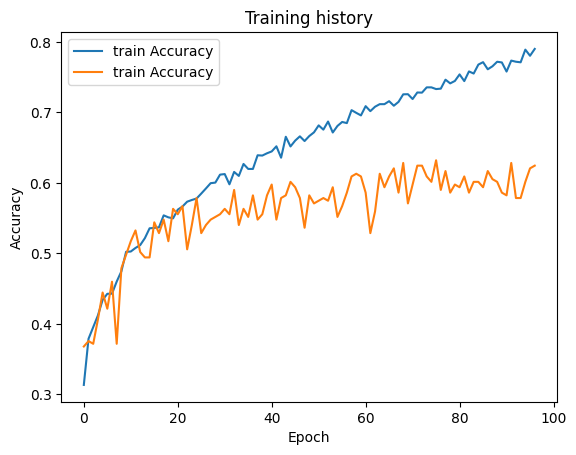

In [49]:
plt.plot(history['train_Accuracy'], label='train Accuracy')
plt.plot(history['val_Accuracy'], label='train Accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


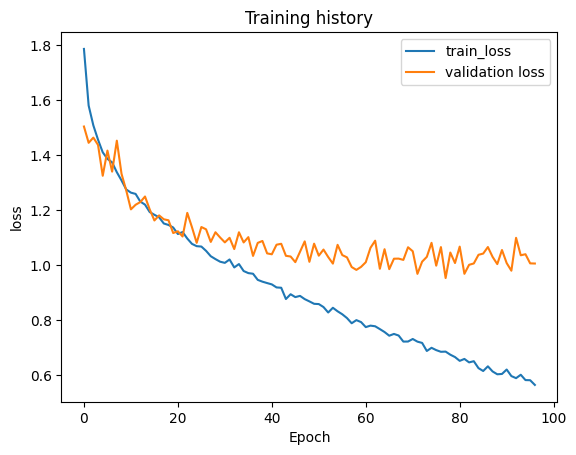

In [50]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()


In [54]:
mean_loss, predicted_labels, true_labels=get_predicted(model,test_dataloader,loss_fn,DEVICE)

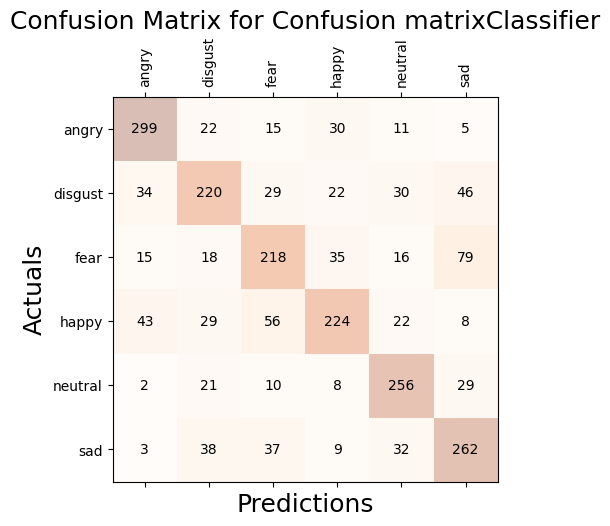

Accuracy : 0.6623
Precision : 0.6626
Recall : 0.6653
F1 Score : 0.6622
Most Confusing Classes:
1. fear: 21.73% (Misclassification rate)
2. disgust: 42.26% (Misclassification rate)
3. happy: 42.78% (Misclassification rate)
4. sad: 41.36% (Misclassification rate)
5. angry: 21.47% (Misclassification rate)
6. neutral: 31.23% (Misclassification rate)


In [55]:
measurements_of_accuracy(true_labels,predicted_labels,"Confusion matrix",list(label_mapping.keys()))

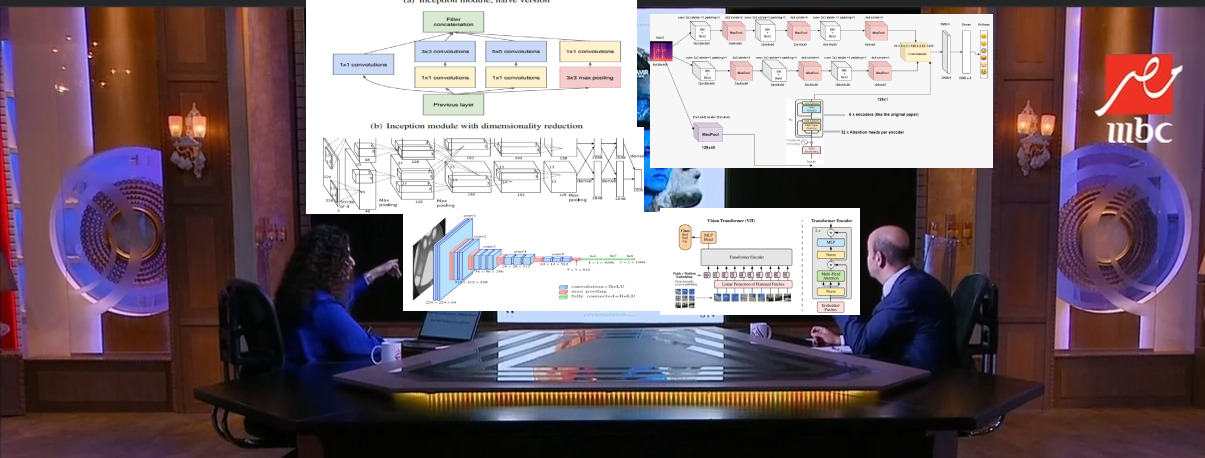
# References so we don't get in trouble !
1. Krizhevsky et al, 2017. ImageNet Classification with Deep Convolutional Neural Networks. https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

2. LeCunn et al, 1998. Gradient-Based Learning Applied to Document Recognition. http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

3. Simonyan and Zisserman, 2015. Very Deep Convolutional Networks for Large-Scale Image Recognition. https://arxiv.org/pdf/1409.1556.pdf

4. Vaswani et al, 2017. Attention Is All You Need. https://arxiv.org/abs/1706.03762

5. DFU_SPNet: A stacked parallel convolution layers based CNN to improve Diabetic Foot Ulcer classification https://www.sciencedirect.com/science/article/pii/S2405959521001120

6. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale https://arxiv.org/abs/2010.11929